In [1]:
import networkx as nx
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from sympy.solvers import solve
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
def get_op(op_code: str):
    if op_code == "+":
        return np.add
    elif op_code == "*":
        return np.multiply
    elif op_code == "-":
        return np.subtract
    elif op_code == "/":
        return np.divide
    else:
        return lambda _x: int(op_code)

def parse_input(filename: str) -> nx.DiGraph:
    graph = nx.DiGraph()
    node_set = set()
    
    def _add_node(node: str) -> None:
        if node not in node_set:
            node_set.add(node)
            graph.add_node(node)

    with open(filename) as f:
        for row in f:
            row = row.rstrip().rsplit(" ")
            if len(row) > 2:
                node_name, op1, op, op2 = row
                node_name = node_name[:-1]
                for node in [node_name, op1, op2]:
                    _add_node(node)
                graph.nodes[node_name]["op"] = op
                graph.nodes[node_name]["op1"] = op1
                graph.nodes[node_name]["op2"] = op2
                graph.add_edge(node_name, op1)
                graph.add_edge(node_name, op2)
            else:
                node_name, op = row
                node_name = node_name[:-1]
                _add_node(node_name)
                graph.nodes[node_name]["op"] = int(op)

    return graph

In [3]:
def traverse_graph(graph: nx.DiGraph, node: str) -> int:
    op = graph.nodes[node]["op"]
    if not isinstance(op, str):
        val = op
    else:    
        op1 = graph.nodes[node]["op1"]
        op2 = graph.nodes[node]["op2"]
        op1 = traverse_graph(graph, op1) if isinstance(op1, str) else op1
        op2 = traverse_graph(graph, op2) if isinstance(op2, str) else op1

        val = get_op(op)(
            op1,
            op2,
        )
    return val

In [4]:
test_tree = parse_input("input.txt")
traverse_graph(test_tree, "root")

159591692827554.0

In [5]:
def prune_val_nodes(graph: nx.DiGraph, node: str, verbose: bool = False) -> None:
    if not isinstance(graph.nodes[node]["op"], str):
        return
    for target in ["op1", "op2"]:
        target_node = graph.nodes[node][target]
        if not isinstance(target_node, str):
            continue
        if not isinstance(graph.nodes[target_node]["op"], str) and not graph.nodes[target_node]["dependent"]:
            if verbose:
                print(f"Removing {node} - {target_node}")
            graph.remove_edge(node, target_node)
            graph.nodes[node][target] = graph.nodes[target_node]["op"]
        else:
            prune_val_nodes(graph, target_node)

def make_graph_compact(graph: nx.DiGraph, node: str, verbose: bool = False) -> None:
    if not isinstance(graph.nodes[node]["op"], str):
        return
    if graph.nodes[node]["dependent"]:
        for neigh in graph.successors(node):
            make_graph_compact(graph, neigh)
    else:
        if verbose:
            print(f"Compacting {node}")
        graph.nodes[node]["op"] = traverse_graph(graph, node)
        graph.remove_edge(node, graph.nodes[node]["op1"])
        graph.remove_edge(node, graph.nodes[node]["op2"])
        del graph.nodes[node]["op1"]
        del graph.nodes[node]["op2"]

def _assert_line_property(graph: nx.DiGraph, root_name: str = "root", human_name: str = "humn") -> bool:
    start_node = root_name
    while start_node != human_name:
        successors = list(graph.successors(start_node))
        if len(successors) > 1:
            print(f"{len(successors)} successors for node {start_node}")
            return False
        start_node = successors[0]
    return True

def traverse_graph_task_2(graph: nx.DiGraph, root_name: str = "root", human_name: str = "humn", verbose: bool = False) -> int:
    op1 = graph.nodes[root_name]["op1"]
    op2 = graph.nodes[root_name]["op2"]

    nx.set_node_attributes(graph, False, "dependent")
    for dependent_node in nx.dfs_preorder_nodes(
        graph.reverse(copy=False), source=human_name
    ):
        graph.nodes[dependent_node]["dependent"] = True
    
    if graph.nodes[op1]["dependent"] and graph.nodes[op2]["dependent"]:
        raise AssertionError("Cannot handle case!")

    make_graph_compact(graph, root_name, verbose=verbose)
    prune_val_nodes(graph, root_name, verbose=verbose)

    assert _assert_line_property(graph, root_name=root_name, human_name=human_name)

    graph.nodes[human_name]["op"] = None
    graph.nodes[root_name]["op"] = "="

    curr_node = human_name
    
    eval_str = ""

    while True:
        if len(list(graph.successors(curr_node))) == 0:
            eval_str = "x"
            curr_node = next(graph.predecessors(curr_node))
            continue

        if not isinstance(graph.nodes[curr_node]["op1"], str):
            eval_str = f"{graph.nodes[curr_node]['op1']}  {graph.nodes[curr_node]['op']} ({eval_str})"
        else:
            eval_str = f"({eval_str}) {graph.nodes[curr_node]['op']} {graph.nodes[curr_node]['op2']}"    
        if curr_node == root_name:
            break
        else:
            curr_node = next(graph.predecessors(curr_node))

    return eval_str, graph

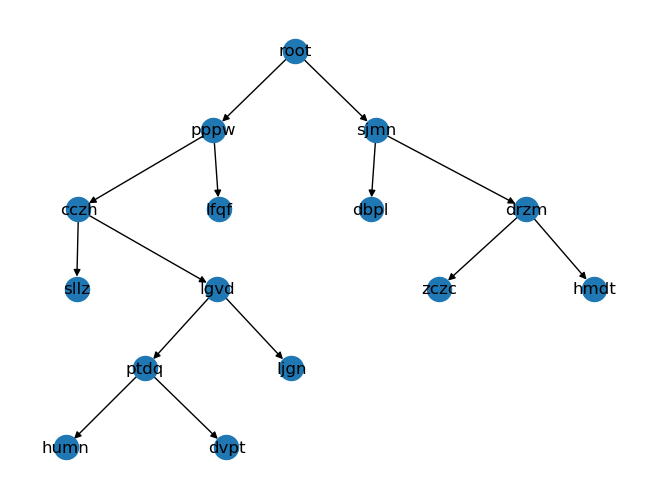

In [6]:
tree = parse_input("test-input.txt")
pos = graphviz_layout(tree, prog="dot")
nx.draw(tree, pos, with_labels="True")

((4  + (2  * ((x) - 3))) / 4) = 150


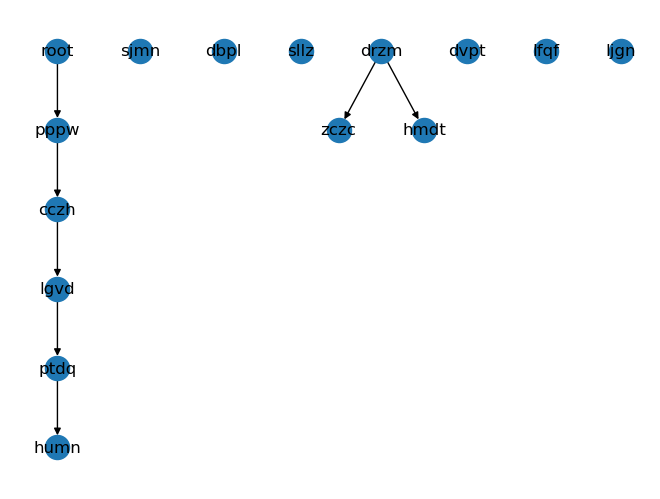

In [7]:
tree_str, tree = traverse_graph_task_2(tree)
pos = graphviz_layout(tree, prog="dot")
nx.draw(tree, pos, with_labels="True")
print(tree_str)

In [8]:
sympy_expr = parse_expr(tree_str, transformations="all")
print(sympy_expr)
solve(sympy_expr, 'x')

Eq(x/2 - 1/2, 150)


[301]

In [9]:
tree = parse_input("input.txt")
tree_str, tree = traverse_graph_task_2(tree)
sympy_expr = parse_expr(tree_str, transformations="all")
solve(sympy_expr, 'x')

[3509819803065]